# About three-point correlations - zero padding complications

Here we investigate the effects of zero-padding on three-point correlation matrices. In contrast to two-point correlations, here we cannot recover certain parts of the correlation matrix.

In [187]:
import numpy as np

# set the plotting
import matplotlib
matplotlib.use('nbagg') # change according to your needs: agg, tkagg, ...
import matplotlib.pyplot as plt
plt.ion()

In [188]:
import scorr

In [189]:
from scipy import fftpack

In [190]:
# use a naive brute-force implementation for comparison (very slow!)
from scorr._cov_matrices_nofft import xmat3pt_nofft

In [191]:
# some helpers
def format_axes(ax):
    ax = np.asanyarray(ax)
    ax[0].set_ylabel('lag 1')
    for a in ax.flatten():
        a.set_frame_on(False)
        a.set_xlabel('lag 2')

def get_imshow_kw(v=1):
    return {'cmap': 'RdBu', 'vmin':-v,'vmax':v}

def get_rect_subplot_kw():
    return {'aspect':'equal', 'adjustable':'box-forced'}

def format_discontinuous_ticks(ax, maxlag):
    for a in [ax.xaxis, ax.yaxis]:
        a.set_major_locator(
            matplotlib.ticker.MultipleLocator(base=maxlag/2)
        )
        a.set_major_formatter(
            matplotlib.ticker.FuncFormatter(
                lambda v,p: np.round((v - (v >= maxlag) * 2*maxlag))
            )
        )
    ax.set_xlim(0, 2*maxlag)
    ax.set_ylim(2*maxlag, 0)

### Generate test data

In [214]:
# simple test data
steps   = 2**10
maxlag  = 2**8 # will have a strong effect on brute-force estimator below!
t       = np.arange(steps)
freq1   = 2 * np.pi / 20.
freq2   = freq1 / 2.
x       = np.sin(t*freq1) + np.sin(t*freq2)

### Calculate covariance matrices

Here we illustrate the basic usage to replace a naive estimator that that becomes too slow if we need large lags

In [215]:
%%time
mx = np.mean(x)
C3_nofft = xmat3pt_nofft(x - mx, x - mx, x - mx, maxlag)

CPU times: user 1.49 s, sys: 8.53 ms, total: 1.5 s
Wall time: 1.5 s


In [216]:
%%time
C3 = scorr.x3corr(x, x, x, nfft=3*maxlag, pad=maxlag, norm='corr')[:maxlag,:maxlag]
# In contrast to the xcorr, we here always set nfft and pad directly to the desird
# integer values since x3corr always averages over segments. As with 1D-FFT, a part of
# of our result contains negative frequencies so we have to be careful about choosing sufficiently
# large windows for our transforms and pad (each window) with zeros. You may even want to 
# choose nfft more than twice as large as the longest lag of interest if you absolutely
# need the highest precision at all lags.

CPU times: user 178 ms, sys: 67 ms, total: 245 ms
Wall time: 216 ms


<IPython.core.display.Javascript object>


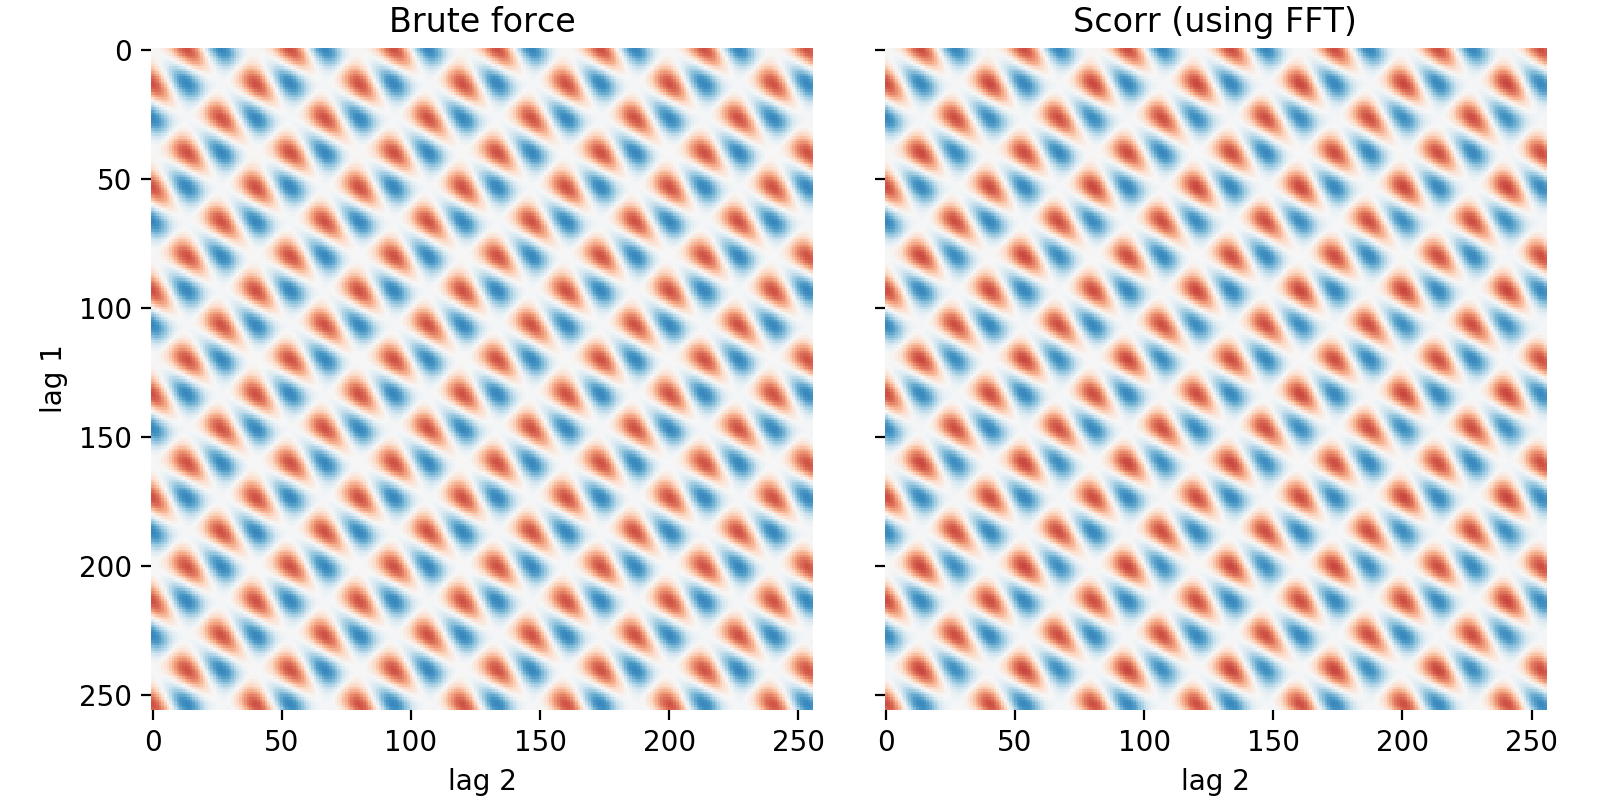

In [217]:
fig, ax = plt.subplots(
    figsize=(8,4), ncols=2, sharex=True, sharey=True, subplot_kw=get_rect_subplot_kw()
)
ikwa = get_imshow_kw(1)

ax[0].set_title('Brute force')
ax[0].imshow(C3_nofft, **ikwa)
ax[1].set_title('Scorr (using FFT)')
ax[1].imshow(C3, **ikwa)
#ax[1].imshow((C3_nofft -C3), **ikwa) # alternatively show difference
#ax[1].imshow(scorr.fftshift(C3), **ikwa)

format_axes(ax)
fig.tight_layout()

# What happens with negetive frequencies for three-point correlatons?

The above section may be all that is necessary to use x3corr. Below we dive deeper into the effects of anticausal mixing and padding.

### 1. Not padding with zeros creates "distortions"
This is problematic because we get negative-frequency mixing as soon as the SUM of the two lags is larger than half the FFT window!

In [10]:
C3_unpadded= scorr.x3corr(x, x, x, nfft=2*maxlag, pad=0)

<IPython.core.display.Javascript object>


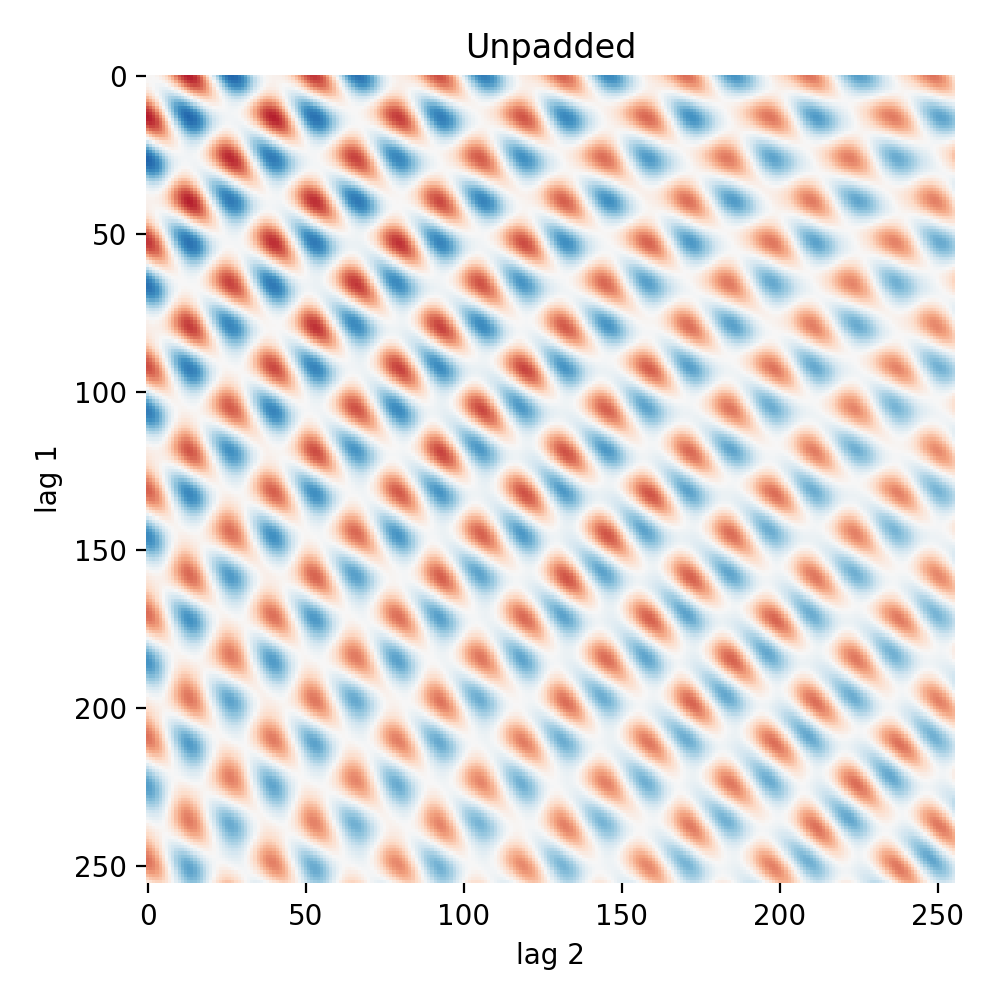

In [11]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw=get_rect_subplot_kw())
ax.set_title('Unpadded')
ax.imshow(C3_unpadded[:maxlag,:maxlag], **get_imshow_kw(.8))
format_axes([ax])
fig.tight_layout()

The effect becomes even more obvious when we plot the full matrix returned by x3corr. In the first quadrant, both lags are positive. In the fourth, both are negative. In the second and third quadrant, on lag is positive and the other negative.

<IPython.core.display.Javascript object>


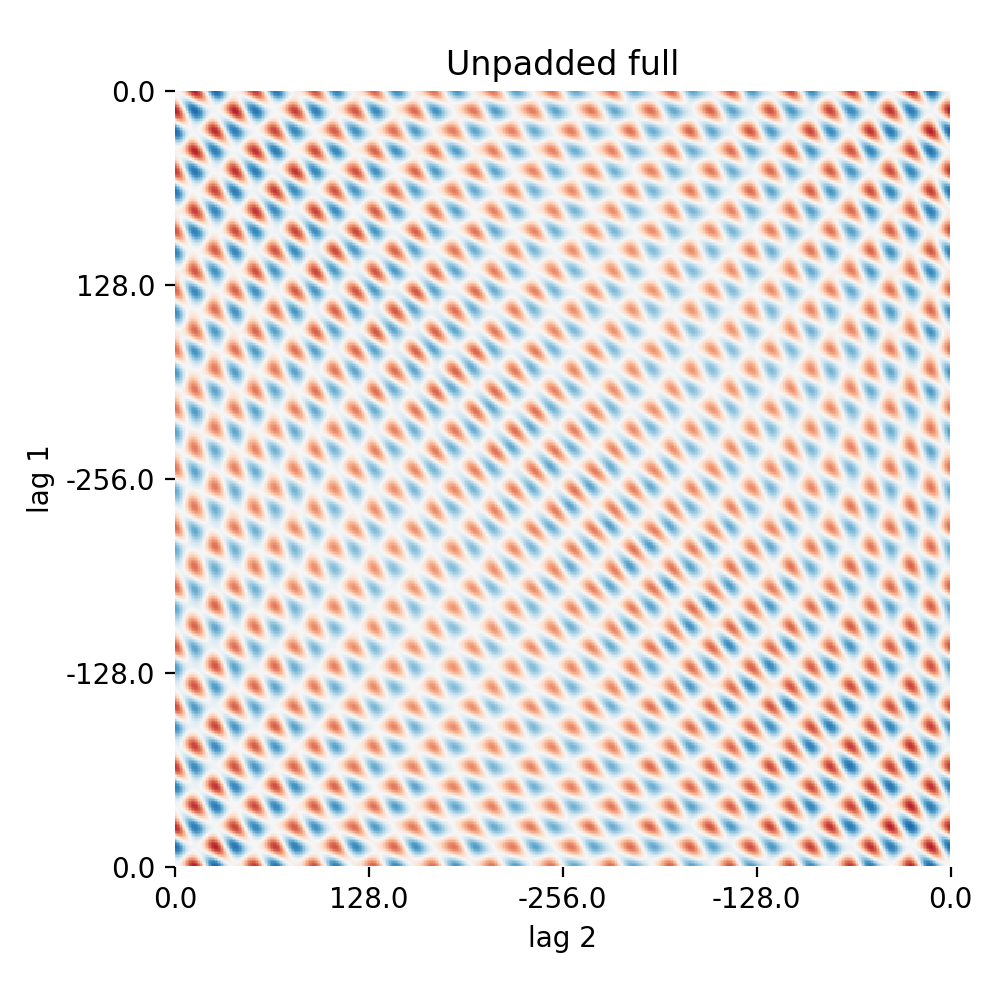

In [12]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw=get_rect_subplot_kw())
ax.set_title('Unpadded full')
ax.imshow(C3_unpadded, **get_imshow_kw(.8))
format_axes([ax])
format_discontinuous_ticks(ax, maxlag)
fig.tight_layout()

### 2. Not correcting the bias has a similar effect as for two-point correlations

Similar to the two-point case, padding with zeros leads to an underestimation of the true correlations due to products where one factor lies in the padded part of the FFT segment.

In [13]:
C3_biased = scorr.x3corr(x, x, x, nfft=2*maxlag, pad=maxlag, debias=False)

<IPython.core.display.Javascript object>


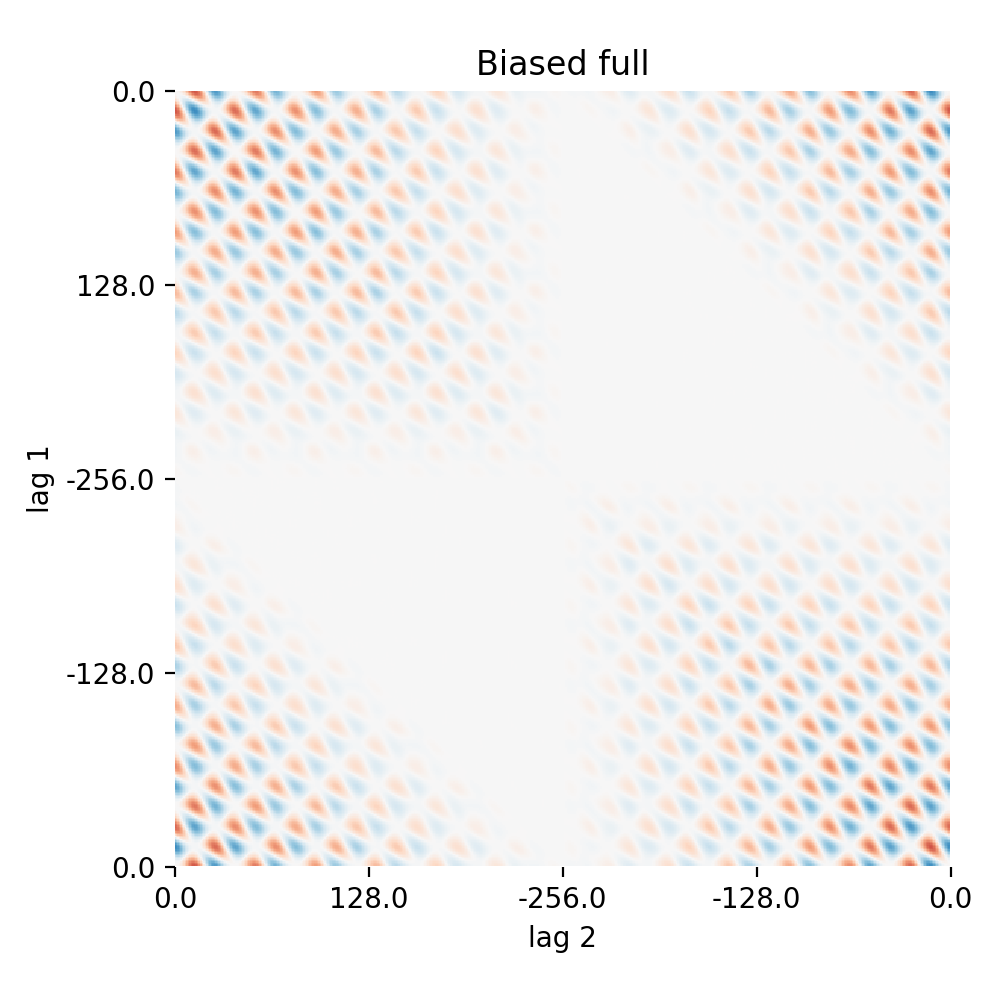

In [14]:
fig, ax = plt.subplots(
    figsize=(5,5), subplot_kw=get_rect_subplot_kw()
)
ax.set_title('Biased full')
ax.imshow(C3_biased, **get_imshow_kw(.5))
format_axes([ax])
format_discontinuous_ticks(ax, maxlag)
fig.tight_layout()

### 3. Demixing cannot recover some parts of the full matrix

We can mostly correct the biases, except for the parts of the correlation matrix where one lag is negative and one is positive and the distance between the observations is longer than the FFT segment. There are some artefacts very close to the boundaries of these areas. This is, however, not too dissimilar from debiasing two-point correlations. It may amplify noise for very long lags, hence the above recommandation to only use lags that are slightly smaller than nnft/2.

In [15]:
C3_unbiased = scorr.x3corr(x, x, x, nfft=2*maxlag, pad=maxlag, debias=True)

<IPython.core.display.Javascript object>


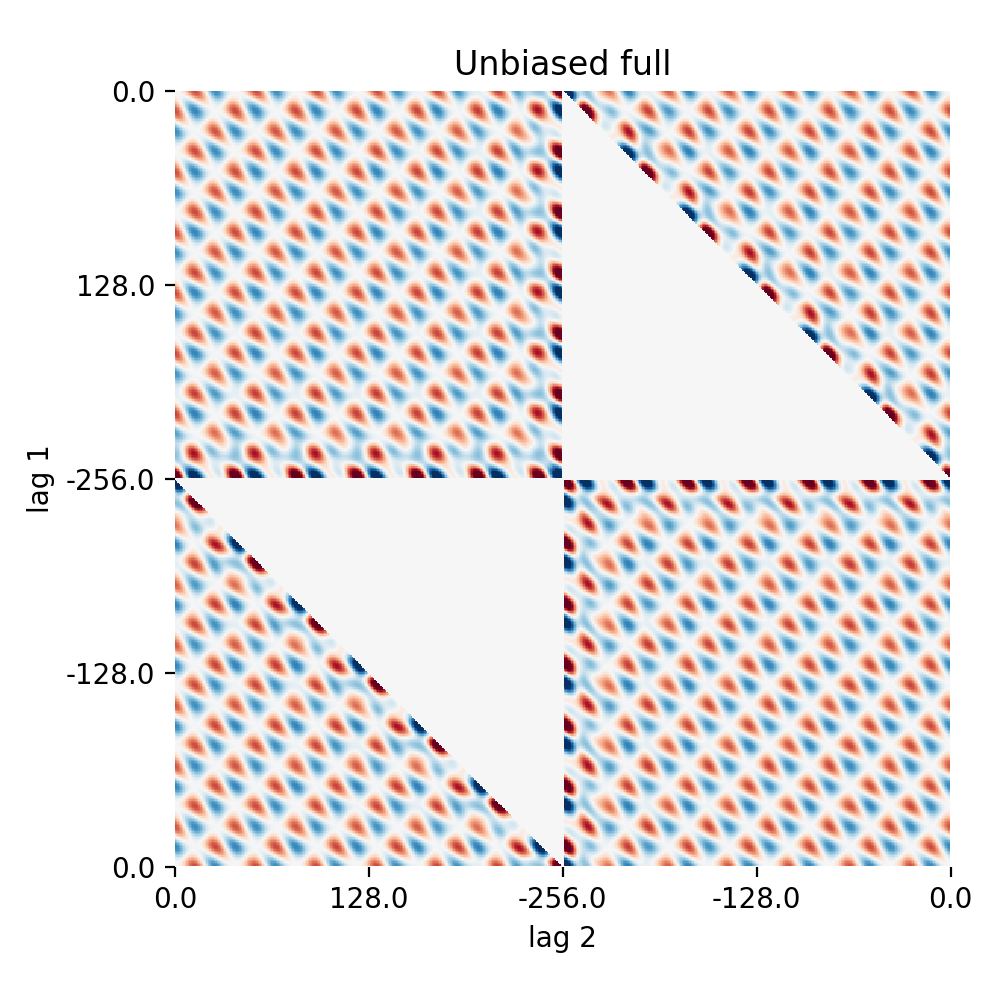

In [16]:
fig, ax = plt.subplots(
    figsize=(5,5), subplot_kw=get_rect_subplot_kw()
)
ax.set_title('Unbiased full')
ax.imshow(C3_unbiased, **get_imshow_kw(1))
format_axes([ax])
format_discontinuous_ticks(ax, maxlag)
fig.tight_layout()

### 4. Centering the full matrix

<IPython.core.display.Javascript object>


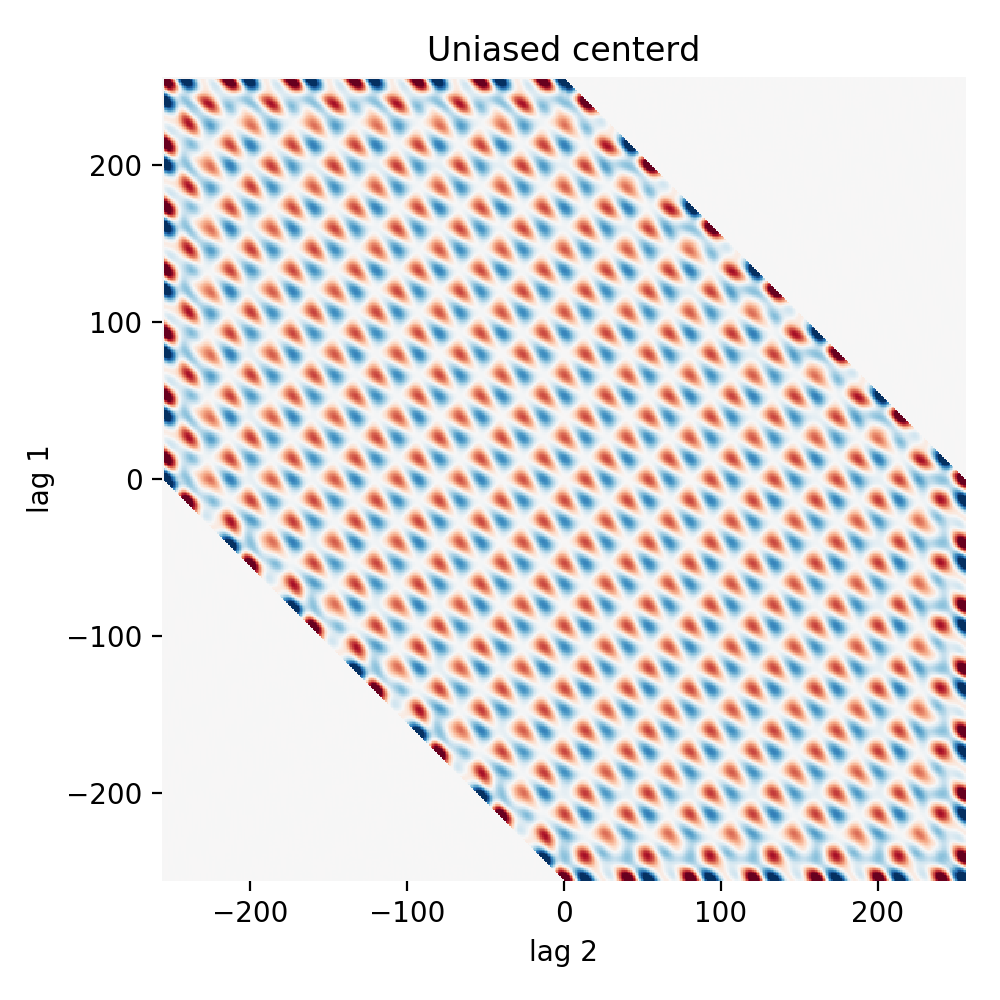

In [17]:
fig, ax = plt.subplots(
    figsize=(5,5), subplot_kw=get_rect_subplot_kw()
)
ax.set_title('Uniased centerd')
ax.imshow(
    scorr.fftshift(C3_unbiased), 
    extent = (-maxlag,maxlag,-maxlag,maxlag),
    **get_imshow_kw(1)
)
format_axes([ax])
fig.tight_layout()

In [ ]:
np.testing.assert_almost_equal

In [219]:
16 * 4

64

---

In [222]:
import pandas as pd

In [421]:
scorr.__reload_submodules__()
reload(scorr)

<module 'scorr' from '/Users/felix/Documents/uni/papers/impact_report/demo_code/packaged/testenv/lib/python2.7/site-packages/scorr/__init__.pyc'>

In [428]:
t = np.arange(128)
dlen = 16
#x = np.sin(t / 3. / np.pi)
#y = np.sin(t / np.pi)
#z = np.cos(t)
x = np.random.randn(len(t))
y = np.random.randn(len(t))
z = np.random.randn(len(t))
C = scorr.x3corr(   
    x, y, z, nfft=32, pad=16
)
df = pd.DataFrame({
    'x': x, 
    'y': y, 
    'z': z, 
    'date': (t/dlen).astype(int)
})
Cdf, Cdfe = scorr.x3corr_grouped_df(df, ['x','y','z'], nfft='demix')

In [429]:
((abs(C) != 0) * (abs(Cdf - C)  / Cdfe)).max()

1.746884377884516

<IPython.core.display.Javascript object>


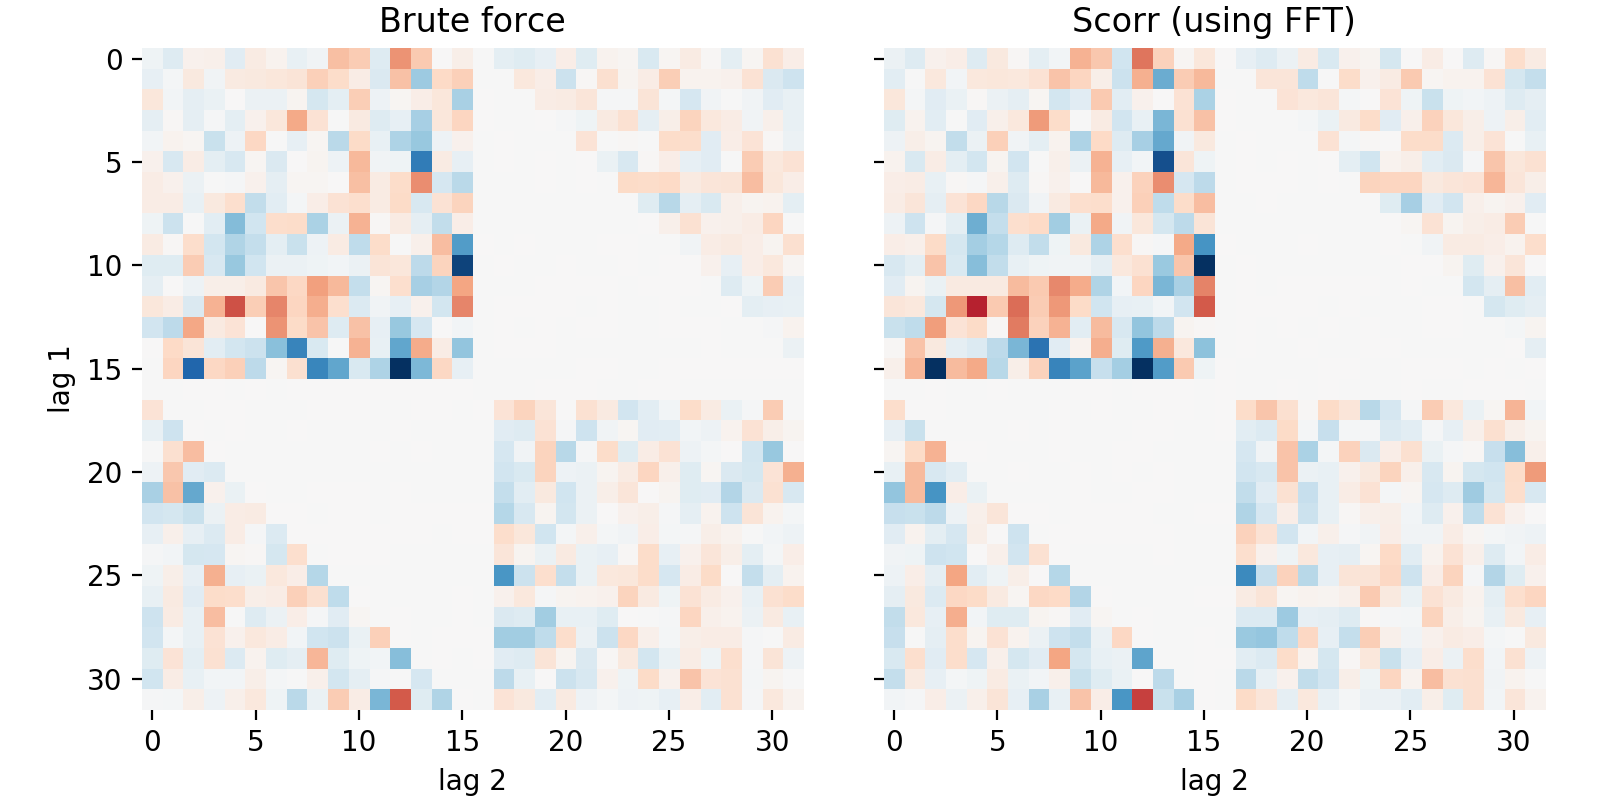

In [430]:
fig, ax = plt.subplots(
    figsize=(8,4), ncols=2, sharex=True, sharey=True, subplot_kw=get_rect_subplot_kw()
)
ikwa = get_imshow_kw(1)

ax[0].set_title('Brute force')
ax[0].imshow(C, **ikwa)
ax[1].set_title('Scorr (using FFT)')
ax[1].imshow(Cdf, **ikwa)
#ax[1].imshow((C - Cdf), **ikwa) # alternatively show difference
#ax[1].imshow(scorr.fftshift(C3), **ikwa)

format_axes(ax)
fig.tight_layout()

In [279]:
(C - Cdf).max()

0.029433192475988412